# Diagramación de una Chacra para Forestería Análoga

### © Equipo I+D SomosAZUCAR - Bajo licencia AGPLv3

```
Diagramador de Planos para Forestería Análoga
Copyright (C) 2015 Sebastian Silva

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

El software a continuación toma una selección de especies con una población propuesta e intenta ubicarla en un terreno según ciertas reglas.

In [1]:
# Bibliotecas utilizadas para confeccionar el mapa
%matplotlib inline
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
from shapely import geometry
from shapely import ops
import numpy as np
import pandas as pd
import random
import mpld3
from tqdm import tqdm

import time

# Para realizar un video
from moviepy import editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage

from copy import deepcopy

# Emular Python3 (tuvimos que revertir a Python2 por MoviePy)
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
import six

# Activar extensión vega para diagramar en línea:
# jupyter nbextension install --py vega --user
# jupyter nbextension enable vega --user --py
plt.ioff()

## 1.- BASE DE DATOS DE CULTIVOS DE BAJÍO AMAZÓNICO
### © Arbio - licencia por definir

La base de datos consiste en una lista de especies, cantidades, diámetro, y características.

In [2]:
especies = pd.read_csv("db_final.csv") ## Es una base
especies = especies[(especies.Usos=="Medicinal")]
especies = especies[(especies.ind>0)]
especies = especies.sort_values(by=['Altura.tot'], ascending=False)

# Filtros posibles de pruebas
#especies = especies.head(8)
#especies = especies.tail(6)
especies

,Usos,Nombre,Sp,Copa,Altura,Bajio,Enredadera,Productividad,Estrato,N,...,C11,C12,Sombra,Distancia,Diametro.dosel,Altura.tot,T1a.produccion,Trecambio,pond,ind
38,Medicinal,Huasai brasilero / palmito,sp11,19.6,False,False,False,24.45,4,0,...,1,1,0.60,5,5,30,60,20.0,0.21,4
34,Medicinal,Coco,sp11,19.6,False,True,False,1.68,4,0,...,0,0,0.00,10,5,30,60,50.0,0.01,4
35,Medicinal,Copaiba,sp11,113.1,False,False,False,9.55,5,0,...,2,2,0.50,8,12,28,96,30.0,0.08,4
43,Medicinal,Pan de arbol,sp11,78.5,False,False,False,12.10,4,0,...,2,2,0.50,10,10,26,90,25.0,0.10,4
27,Medicinal,Aguaje,sp11,28.3,False,True,False,21.22,4,0,...,1,2,0.00,18,6,25,90,45.0,0.18,4
50,Medicinal,Sangre grado,sp11,38.5,False,False,False,5.26,5,0,...,0,0,0.70,7,7,24,90,18.0,0.05,4
51,Medicinal,Sapote,sp11,113.1,False,False,False,7.37,4,0,...,0,0,0.65,12,12,20,102,18.0,0.06,4
45,Medicinal,Pijuayo,sp11,19.6,False,False,False,3.82,4,0,...,0,0,0.00,6,5,20,42,20.0,0.03,4
40,Medicinal,Mango,sp11,78.5,False,False,False,19.10,4,0,...,2,2,0.40,11,10,20,96,20.0,0.16,4
52,Medicinal,Shimbillo,sp11,28.3,False,False,False,3.09,3,1,...,0,0,0.00,5,6,16,54,15.0,0.03,7


Obtenemos un consolidado por estrato para hacernos una idea:

In [3]:
consolidado = pd.DataFrame({'especies':especies.groupby('Estrato').size(), 
                            'individuos':especies.groupby('Estrato')['ind'].sum()})
pd.concat([consolidado,pd.DataFrame(consolidado.sum(axis=0),columns=['Total']).T])


,especies,individuos
1,4,612
2,6,132
3,8,56
4,7,28
5,2,8
Total,27,836


## 2.- Linderos de las Chacra

Los linderos están definidos como un polígono en metros, desde la ezquina inferior izquierda.

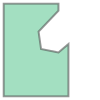

In [4]:
chacra = geometry.Polygon([ [0,0],
                            [0, 93],
                            [55, 93],
                            [55, 86],
                            [35, 65],
                            [37.5, 47.5],
                            [55, 44],
                            [65, 52.5],
                            [65, 0] ])
chacra

Corresponde a una chacra de media hectárea:

In [5]:
print (chacra.area, "m²")

5028.75 m²


Los puntos de esta grilla pueden posteriormente ser transformados en latitud/longitud para su ubicación con un GPS.

## 3.- Definir ubicaciones

El algoritmo consiste en un *bucle* que escoge puntos dentro del polígono que representa una chacra.

El objetivo es llegar a definir la ubicación de cada individuo de una población a partir de:
- una superficie
- lista de especies (incluyendo cantidad de individuos)

Para ello se deben respetar algunas reglas, las cuales han sido separadas y descritas respectivamente.


In [6]:
class Poblacion:
    def __init__(self, poligono, especies, make_frame=None):
        self.poligono = poligono
        self.especies = especies
        
        # Creamos una tabla para almacenar los individuos
        individuos_columns = ['id', 'pos', 'x', 'y', 'color', 'Diametro.dosel', 
                              'Nombre', 'Estrato', 'Diametro.punto', 'Altura.tot']
        self.individuos = pd.DataFrame( columns=individuos_columns, )
        self.n_individuos = 0
        
        # También almacenaremos a los individuos que no pudimos ubicar (de ser el caso)
        self.excluidos = pd.DataFrame( columns=individuos_columns, )
        self.inubicables = 0
        self.exclusiones = []
        
        colores = get_colormap(len(especies))
        
        i=0
        for especie in tqdm(list(especies.itertuples())):
            i=i+1
            n_especie = especie[0]
            color_especie = colores(i)
            planta_tipo = especies.loc[n_especie]
            for n_individuo in range(especies.ind[n_especie]):
                self.n_individuos = self.n_individuos + 1
                planta = planta_tipo.copy()
                planta['id'] = n_especie
                
                #### Algoritmo para ubicar la planta ###
                intentos = 10
                while intentos:
                    intentos = intentos - 1
                    distancia_min = 1 # 1m

                    # Ubicamos un punto aleatorio *random* dentro del polígono            
                    (minx, miny, maxx, maxy) = self.poligono.bounds
                    while True:
                        p = geometry.Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
                        if poligono.contains(p):
                            pos = p
                            break

                    planta['pos'] = pos
                    planta['x'], planta['y'] = pos.xy

                    try:
                        regla_1(self, planta)
                        regla_2(self, planta)
                        regla_3(self, planta)
                    except ValueError as e:
                        self.exclusiones.append(str(e))
                        self.inubicables = self.inubicables + 1
                        planta['pos'] = None          
                        next
                    else:
                        if make_frame:
                            make_frame(self)
                        break

                
                ########################## Fin Algoritmo Ubicación
                
                if planta['pos']:
                    planta['color'] = color_especie
                    planta['Diametro.dosel'] = float(planta['Diametro.dosel'])
                    planta['Diametro.punto'] = float(planta['Diametro.dosel']*10)
                    self.individuos.loc[self.n_individuos] = planta
                else:
                    self.excluidos.loc[self.inubicables] = planta
                self.individuos = self.individuos.dropna()
        
        self.individuos = self.individuos.sort_values(by=['Altura.tot'], ascending=False)

        if self.inubicables:
            print ("No se pudieron ubicar " + str(self.inubicables) + " individuos.")
            #self.inubicables = pd.DataFrame(self.inubicables)

El algoritmo que *ubica* las plantas, lo hace iterando por la lista de especies, desde las más altas a las más pequeñas, probando en orden una lista de reglas que deben cumplirse siempre:

In [7]:
def regla_1(poblacion, planta):
    if planta.Estrato < 3:
        if planta.pos.distance(poblacion.poligono.exterior) < planta['Altura.tot'] * 0.3:        
            raise ValueError('regla1')
    else:
        if planta.pos.distance(poblacion.poligono.exterior) < planta['Altura.tot'] * 0.3:        
            raise ValueError('regla1')

**Regla 1:** La la distancia de una lindero mínimo un 65% de su altura total máxima, o 30% para plantas de estratos 1 y 2. 

In [8]:
def regla_2(poblacion, planta):
    for anterior in poblacion.individuos.itertuples():
        if planta.Estrato < 3:
            distancia_min = (planta.Distancia / 2 ) - (planta.Distancia / 2) * planta.Sombra * 2
        else:
            distancia_min = planta.Distancia / 2
        if planta.pos.distance(anterior[2]) < distancia_min:
            raise ValueError('regla2')

**Regla 2**: La distancia entre las plantas de estratos inferiores será proporcional a la sombra que toleran.

In [9]:
def regla_3(poblacion, planta):
    mi_estrato = int(especies.Estrato[planta.id])
    mas_cercanos = []
    for anterior in poblacion.individuos.itertuples():
        if not mas_cercanos:
            mas_cercanos = [anterior]
        for cercano in mas_cercanos:
            if planta.pos.distance(anterior[2]) < planta.pos.distance(cercano[2]):
                mas_cercanos.append(anterior)
                if len(mas_cercanos) == 3:
                    mas_cercanos.pop(0)
                
    for cercano in mas_cercanos:
        if abs(especies.Estrato[int(cercano[1])] - mi_estrato) > 1:
            raise ValueError('regla3')

**Regla 3**: Una de las tres plantas más cercanas debe ser de un estrato adyacente, inmediatamente mayor o menor.

# Proceso de Renderizado

## Definir el mapa de colores para los árboles: *f(Altura)*

Utilizamos una escala de colores para terrenos de mapas.

In [10]:
def get_colormap(N):
    color_norm  = colors.Normalize(vmin=0, vmax=N-1)
    scalar_map = cmx.ScalarMappable(norm=color_norm, cmap='terrain') 
    def map_index_to_rgb_color(index):
        return scalar_map.to_rgba(index)
    return map_index_to_rgb_color
# http://stackoverflow.com/questions/14720331/how-to-generate-random-colors-in-matplotlib

In [11]:
class Figure:
    def __init__(self, poblacion=None):
        self.colores = None
        self.poligono = None
        self.fig = plt.figure(figsize=(7, 7))

        self.ax = self.fig.add_subplot(111)
        self.ax.set_ylim(-10,100)
        self.ax.set_xlim(-20,90)

        self.ax.grid(color='gray', alpha=0.9)
        
        if poblacion:
            self.plot_poblacion(poblacion)
            
        # Barra de colores
        #       def createColourbar(lwr, upr):
        #   """Create a colourbar with limits of lwr and upr"""
        #    cax, kw = colorbar.make_axes(plt.gca())
        #    norm = colors.Normalize(vmin = lwr, vmax = upr, clip = False)
        #    c = colorbar.ColorbarBase(cax, cmap=plt.cm.get_cmap('terrain_r'), norm=norm)
        #    return c

        #cb = createColourbar(0, len(pob.especies)-1)
        #cb.set_label('ESPECIES', labelpad=-50, y=0.45)

        #cb.set_ticks(list(reversed(range(0, len(pob.especies)-1))))
        #cb.set_ticklabels(list(pob.especies.Nombre))
        #try:
        #    cb.autoscale()
        #    self.fig.colorbar(cb)
        #except TypeError:
        #    pass
        
    def plot_poblacion(self, poblacion):        
        colormap = cmx.ScalarMappable(
                    colors.Normalize(1, len(especies)),
                    plt.cm.get_cmap('terrain'))
        
        if not self.colores:
            cm = plt.cm.get_cmap('terrain')
            colores = [list(cm(x)) for x in range(len(poblacion.especies))]
            self.colores = list(reversed(colores))
        
        if not self.poligono:
            self.ax.plot( *poblacion.poligono.exterior.xy )

        # Los círculos y puntos representan a cada individuo
        circulos = []
        colores = []
        puntos_x = []
        puntos_y = []
        labels = dict()
        for planta in poblacion.individuos.iterrows():
            circulos.append(planta[1]['pos'].buffer(planta[1]['Diametro.dosel']))
            colores.append(planta[1]['color'])
            puntos_x.append(planta[1]['x'])
            puntos_y.append(planta[1]['y'])
            labels[planta[1]['id']]=planta[1]['Nombre']

        i=0
        for poligono in circulos:
            patch = PolygonPatch(poligono, fc=colores[i-1], alpha=0.2, zorder=1)
            self.ax.add_patch(patch)
            i = i+1
            
        self.ax.scatter(puntos_x, 
                puntos_y, 
                c=colores,
                s=20,
                cmap="terrain",
                vmin=0,
                vmax=len(poblacion.especies)-1,
                alpha=0.6, marker="+")

In [12]:
starttime = time.time()
frames = {}

In [ ]:
def save_frame(poblacion):
    f = Figure(poblacion)
    t = time.time() - starttime
    img_array = mplfig_to_npimage(f.fig)
    frames[t] = img_array
    del(f)

In [ ]:
# Demora unos 3 minutos
pob = Poblacion(chacra, especies, save_frame)

 48%|████▊     | 13/27 [00:14<00:23,  1.68s/it]

In [ ]:
seconds = sorted(frames.keys())[-1] - sorted(frames.keys())[-0]

In [ ]:
def make_frame(t):
    keyframes = sorted(frames.keys())
    t_min = min(keyframes)
    this_frame = frames[min(keyframes, key=lambda x:abs(x-t-t_min))]
    return this_frame

anim = mpy.VideoClip(make_frame, duration=seconds)

anim.write_videofile("vis_algoritmo.mp4", fps=50)

In [ ]:
print ("Se ubicaron %s de %s individuos." % 
        ( len(pob.individuos), especies.ind.sum(axis=0)))

Se puede ver qué tantas veces una regla descartó un punto, y tomarlo como un indicador de qué tan estricta es una regla.

In [ ]:
exclusiones = pd.DataFrame({'regla':pob.exclusiones})
pd.DataFrame({'causales de exclusión':exclusiones.groupby('regla').size()})

Algunas plantas pueden haber quedado excluidas por no poder ser ubicadas satisfactoriamente.

En ese caso se sugiere ajustar las reglas o la tabla de especies. Aquí se dejan algunas formas de analizar los datos generados.

In [ ]:
pd.DataFrame({'excluidos':pob.excluidos.groupby('Nombre').size()})

## 4.- Graficar el mapa

A continuación se grafica el mapa de acuerdo a las ubicaciones computadas.

In [ ]:
f = Figure(pob)

In [ ]:
#from vega import VegaLite

In [ ]:
"""VegaLite({
  "mark": "point",
  "encoding": {
    "y": {"type": "quantitative","field": "y"},
    "x": {"type": "quantitative","field": "x"}
  }
}, pob.individuos)"""

In [ ]:
# Gráfico interactivo (no funciona en github)
# mpld3.display(fig)